# **Pseudotimes and cell fates**

---------------------------

**Motivation:**

While clustering is an useful type of analysis to try giving a structure to the development of cells towards their final stage (spermatozoa), it does not give an understanding of how the development "stretches" from start to end. For example, a cluster can have many cells and look "big" on UMAP, but actually its variability in terms of gene expressions could be low. Also, a developmental process can branches towards different ends (cell fates) or developmental checkpoints (e.g. stages where damaged cells express specific genes for apoptosis/cell death). Pseudotime and cell fates analysis can be used to hgihlight exactly those processes.
- **Pseudotimes** assigns to each cell the value of a timeline, starting from 0 for the cells at the beginning of the development. This value is purely a reference for ordering the cells development, but pseudotimes at specific stages can be assigned to real times, using previous biological knowledge.
- **Cell fates analysis** looks at the PCA projection of the data and the pseudotime of each data point on the PCA. From this, it tries to create a tree connecting the cells, so that the end branches of the tree are different end points or stages of the developmental process.


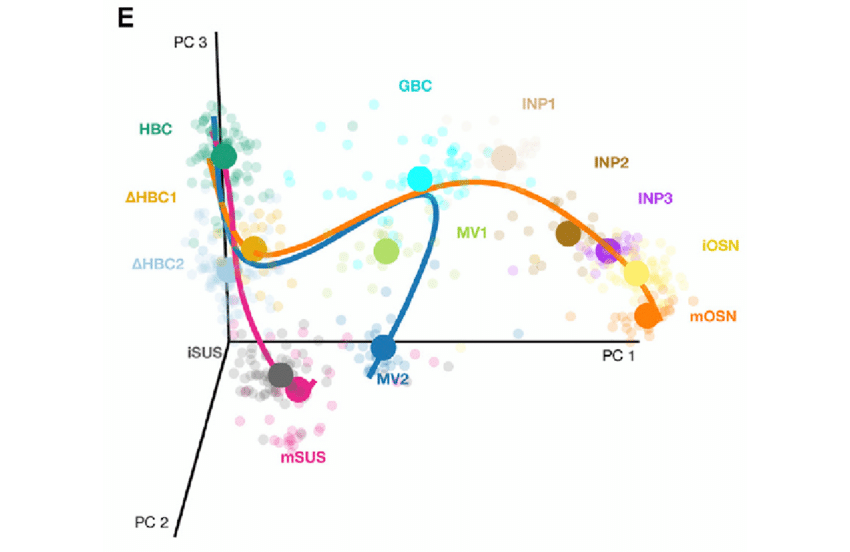
*Figure: cell fates tree on a 3D pca plot. Circles represent the middle point of each cluster. From Perredaeau et al. (2017)*

---------------------------

**Learning objectives:**
- Understand and determine the pseudotimes on a single cell dataset
- Infer cell fates and distinguish between differentiation stages or actual final developmental stages
- Compare gene expressions along differentiation
- Cluster genes with similar gene expression
----------------
**Execution time: 45 minutes**

---------------

***Import packages***

In [ ]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import anndata as ad

***Read data***

In [ ]:
sample = sc.read('../../../Data/notebooks_data/crypto_123.filt.norm.red.clst.2.h5ad')

## Calculate pseudotimes and cell fates

We want to calculate pseudotimes on the spermatogenic process. We exclude the somatic cells from.

In [ ]:
#cellsToKeep = [ i not in ['Leydig','Endothelial','Myoid'] for i in sample.obs['clusters'] ]
cellsToKeep = [ i not in ['Endothelial','Myoid'] for i in sample.obs['clusters_spc'] ]
sample = sample[ cellsToKeep, : ].copy()

we use the `python` package `palantir`

In [ ]:
import palantir
palantir.core.random.seed( a=12345 ) #define random_state (here called 'a')

we create a table (`pandas` dataframe) with the logarithm of the corrected UMI matrix, since `palantir` needs logarithmized raw counts in input

In [ ]:
palantir_data = pd.DataFrame(np.log1p(sample.layers['umi_sct'].todense()),
                             index=sample.obs_names,
                             columns=sample.var_names)

Instead of letting the package calculate the PCA (without any form of datasets integration), we use our integrated PCA.

In [ ]:
pca_projections = pd.DataFrame( sample.obsm['X_pca'][:,0:10].copy(),
                                index=sample.obs_names )     

Now we will infer the pseudotimes and related cell fates. We have to provide where the differentiation process starts from. In our case, we will choose one of the cells in the cluster `SpermatogoniaA`. Then `Palantir` will assign the pseudotimes=0 to the most appropriate cell in the cluster.
Note the option `num_waypoints=100` in the last command. This option will use a certain number of cells to build the tree from which to calculate pseudotimes and cell fates. it is suggested to use only a portion of cells from the dataset, since using all cells will make you experience the inference of many cell fates that are mostly due to noise. In other words, you will build a tree with some tiny branches that will be detected as cellular fates. 

In [ ]:
ORIGIN_STATE = 'SpermatogoniaA' #where to start
sc.tl.diffmap(sample)
diffusionMap = pd.DataFrame(sample.obsm['X_diffmap'][:,1::], 
                             index=sample.obs_names,
                             columns = [str(i) for i in range(sample.obsm['X_diffmap'].shape[1]-1)])
#apply palantir
start_cell = str(sample[sample.obs['clusters_spc'] == ORIGIN_STATE].obs_names[0]) #assignment of diferentiation start
pr_res = palantir.core.run_palantir( diffusionMap, early_cell=start_cell, num_waypoints=500) #fate detection

We save pseudotimes in our dataset and plot them on UMAP

In [ ]:
sample.obs['pseudotime'] = pr_res.pseudotime

In [ ]:
sc.pl.umap( sample, color=['clusters_spc','pseudotime'], 
           legend_loc='on data', 
           legend_fontsize=16,
           ncols=2 )

We can look at how pseudotimes are distributed into each cluster. It seems the variability of pseudotimes increases along spermatogenesis. This can mean more variability in the expression of genes in the later clusters (but does not mean that there are more genes that are expressed). Note that there are considerable overlapping in pseudotimes. This is due to the fact that pseudotimes have a spike around Pachytene-Diplotene stages, probably due to a small branching of the differentiation process. We should find a fate there.

In [ ]:
sc.pl.violin(sample, keys='pseudotime', groupby='clusters_spc', rotation=90,
            order=['SpermatogoniaA', 'Leptotene', 'Zygotene', 
                   'Pachytene', 'Diplotene', 'RoundSpermatids',
                   'ElongSpermatids'])

## Analysis of cell fates

we can see how many fates we have. For each fate, there is the barcode of the cell best representing a differentiation stage. It seems that we have two fates

In [ ]:
fates = list(pr_res.branch_probs.columns)

In [ ]:
fates

We can plot them on the UMAP plot. One fate is clearly the end of spermatogenesis, where cells become elongated spermatids and spermatozoa.There is another fate, probably due to something happening during meiosis.

In [ ]:
f, ax = plt.subplots(1,1)

sc.pl.umap( sample,
           legend_loc='on data', 
           legend_fontsize=16, ax=ax, show=False)

coordinates = sample[fates].obsm['X_umap']
ax.plot(coordinates[:,0],coordinates[:,1],'o',markersize=12) 
for i in range(coordinates.shape[0]):
    ax.text(coordinates[i,0]-1,coordinates[i,1]-2, f'Fate {i}')
    ax.set_title("Inferred cell fates")
plt.show()

For practical purpose, we rename the two fates as follows

In [ ]:
pr_res.branch_probs.columns = ['LEPTOTENE', 'DIPLOTENE', 'ZYGOTENE', 'SPERM']

We save in our data the probability that each cell differentiate into one of the fates

In [ ]:
for i in pr_res.branch_probs.columns:
    sample.obs[f'branch_prob_{i}'] = pr_res.branch_probs[i]

### Recognizing branchings or developmental stages

A good practice is to look at the probabilities of ending in a fate for each cluster. If the MEIOSIS fate is really a branching, then only some of the cells should end up to that fate. If MEIOSIS is just a stage of the spermatogenesis, than we should see all cells before that point associate with the MEIOSIS stage, and all the others associated with the SPERM stage. That is exactly what happens here.  

In [ ]:
f, ax = plt.subplots(1,1)

sc.pl.violin(sample, groupby='clusters_spc', keys='branch_prob_SPERM', rotation=90,
            order=['SpermatogoniaA', 'Leptotene', 'Zygotene', 
                   'Pachytene', 'Diplotene', 'RoundSpermatids',
                   'ElongSpermatids'], ax=ax, show=False)
ax.set_title('branch probabilities for SPERM cell fate')
plt.show()

In [ ]:
f, ax = plt.subplots(1,1)

sc.pl.violin(sample, groupby='clusters_spc', keys='branch_prob_LEPTOTENE', rotation=90,
            order=['SpermatogoniaA', 'Leptotene', 'Zygotene', 
                   'Pachytene', 'Diplotene', 'RoundSpermatids',
                   'ElongSpermatids'], ax=ax, show=False)
ax.set_title('branch probabilities for LEPTOTENE cell fate')
plt.show()

In [ ]:
f, ax = plt.subplots(1,1)

sc.pl.violin(sample, groupby='clusters_spc', keys='branch_prob_ZYGOTENE', rotation=90,
            order=['SpermatogoniaA', 'Leptotene', 'Zygotene', 
                   'Pachytene', 'Diplotene', 'RoundSpermatids',
                   'ElongSpermatids'], ax=ax, show=False)
ax.set_title('branch probabilities for ZYGOTENE cell fate')
plt.show()

In [ ]:
f, ax = plt.subplots(1,1)

sc.pl.violin(sample, groupby='clusters_spc', keys='branch_prob_DIPLOTENE', rotation=90,
            order=['SpermatogoniaA', 'Leptotene', 'Zygotene', 
                   'Pachytene', 'Diplotene', 'RoundSpermatids',
                   'ElongSpermatids'], ax=ax, show=False)
ax.set_title('branch probabilities for DIPLOTENE cell fate')
plt.show()

### Exploring gene expression and clusters

Here there is a script that plots genes expressions of your choice along pseudotimes. This allows you to see how specific genes behave differently for different fates. Expressions are modeled using the fate probabilities we plotted above. Plotting the gene patterns for different fates is more useful when there are actual branchings involved. When you have different stages, you will see expression of meiosis and pre-meiosis genes for the MEIOSIS fate, and post-meiosis genes expressed for the SPERM fate.

In [ ]:
GENES = ['PIWIL1','PIWIL2','PIWIL3']
GENES = np.intersect1d(GENES, sample.var_names)
NGENES = len(GENES)
CLUSTERS = sample.obs['clusters_spc']
PSEUDOTIMES = sample.obs['pseudotime']
gene_trends = palantir.presults.compute_gene_trends(pr_res, 
                                                    pd.DataFrame(sample.layers['norm_sct'], 
                                                    index=sample.obs_names,
                                                    columns=sample.var_names).loc[:, GENES] 
                                                   )

plt.rcParams['figure.figsize']=(12,8*int(NGENES))
fig, ax = plt.subplots(NGENES,1)

c = CLUSTERS
x = PSEUDOTIMES


if(NGENES==1):
    x2 = []
    t = []
    style = []
    for FATE in list(gene_trends.keys()):
        ARRAY = np.array( gene_trends[FATE]['trends'].loc[GENES[0],:].index )
        for i in ARRAY:
            idx = np.argmin(np.abs(x - i))
            x2.append(c[idx])
            t.append(i)
        if(len(style)==0):
            style = np.tile( FATE, 500 )
            y = np.array(gene_trends[FATE]['trends'].loc[GENES[0],:])
        else:
            style = np.append(arr=style, 
                      values=np.tile( FATE, 500 ))
            y = np.append(arr=y, 
                      values=np.array(gene_trends[FATE]['trends'].loc[GENES[0],:]))
        
    sns.lineplot(x=t,
             y=y, ci=False, 
             hue=x2, ax=ax, style = style,
             linewidth = 5)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(xlabel = 'Pseudotime', ylabel=GENES[0])  
    
if(NGENES>1):      
    for GENE_NR in range(NGENES):
        style = []
        x2 = []
        t = []
        for FATE in list(gene_trends.keys()):
            ARRAY = np.array( gene_trends[FATE]['trends'].loc[GENES[GENE_NR],:].index )
            for i in ARRAY:
                idx = np.argmin(np.abs(x - i))
                x2.append(c[idx])
                t.append(i)
            if(len(style)==0):
                style = np.tile( FATE, 500 )
                y = np.array(gene_trends[FATE]['trends'].loc[GENES[GENE_NR],:])
            else:
                style = np.append(arr=style, 
                              values=np.tile( FATE, 500 ))
                y = np.append(arr=y, 
                              values=np.array(gene_trends[FATE]['trends'].loc[GENES[GENE_NR],:]))
        sns.lineplot(x=t,
                             y=y, ci=False, 
                             hue=x2, ax=ax[GENE_NR],
                             style = style, linewidth = 5, legend=GENE_NR==0)
        ax[GENE_NR].set(ylabel = GENES[GENE_NR])
        if(GENE_NR==0):
            ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            ax[0].set_title(f'Gene expression along the fates:\n{list(gene_trends.keys())}')
    ax[GENE_NR].set(xlabel = 'Pseudotime')   

plt.rcParams['figure.figsize']=(6,6)

**Gene clustering:**
A last thing you can do is to cluster together genes that have the same expression patterns. We can try to do this for each different fate. Here we look at the MEIOSIS fate.

For making the clustering faster, we cluster together only the differentially expressed genes we found in the previous analysis. However, below you can define the variable `genes` as any list of genes. You can for example read them from a text file, or you can use all possible genes by writing `genes=list(sample.var_names)`

In [ ]:
genes = []
for names in sample.uns['DE_clusters_spc']['names']:
    genes.append( list( names ) )

In [ ]:
genes = np.unique(np.ravel(genes))

model the gene expression along pseudotime

In [ ]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, 
                                         pd.DataFrame(sample[ :, genes ].layers['norm_sct'], 
                                         index=sample[ :, genes ].obs_names,
                                         columns=sample[ :, genes ].var_names) )

cluster the expressions together and plot clusters. If you see that there should be more clusters than the algorithm calculates, you can try to increase their number by changing the value of `k=20`. Usually, you should see a lot of genes expressed (in gray colour) differently from their averaged expression (in blue colour)

In [ ]:
trends = gene_trends['SPERM']['trends']
gene_clusters = palantir.presults.cluster_gene_trends(trends, k=20)

In [ ]:
palantir.plot.plot_gene_trend_clusters(trends, gene_clusters)

Here there is a script to produce the plot of the averaged expression of each gene cluster coloured by cell types, together with confidence bands. It takes some time to do all the plots, so be patient.

In [ ]:
GENE_CLST = np.array(gene_clusters)
UNIQUE_CLST = np.sort(np.unique(GENE_CLST))
CLST_NR = int(len(UNIQUE_CLST))
CLUSTERS = sample.obs['clusters_spc']
PSEUDOTIMES = sample.obs['pseudotime']

plt.rcParams['figure.figsize']=(12,4*CLST_NR)
fig, ax = plt.subplots(CLST_NR,1)

c = CLUSTERS
x = PSEUDOTIMES

if(CLST_NR==1):
    t = []
    x2 = []
    ARRAY = np.array( trends.columns )
    for i in ARRAY:
        idx = np.argmin(np.abs(x - i))
        x2.append(c[idx])
        t.append(i)
    
    x=np.tile(ARRAY,trends.loc[GENE_CLST==0,:].shape[0])
    y=np.array(trends.loc[GENE_CLST==0,:]).ravel()
    hue=np.tile(x2,trends.loc[GENE_CLST==0,:].shape[0])
    ax = sns.lineplot(x=x, y=y, hue=hue)
        
    sns.lineplot(x=x, y=y, hue=hue, 
                 ax=ax, linewidth = 5)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
if(CLST_NR>1):
    ARRAY = np.array( trends.columns )
    t = []
    x2 = []
    for i in ARRAY:
        idx = np.argmin(np.abs(x - i))
        x2.append(c[idx])
        t.append(i)
    for CLST_NR in UNIQUE_CLST:
        x=np.tile(ARRAY,trends.loc[GENE_CLST==CLST_NR,:].shape[0])
        y=np.array(trends.loc[GENE_CLST==CLST_NR,:]).ravel()
        hue=np.tile(x2,trends.loc[GENE_CLST==CLST_NR,:].shape[0])
        
        sns.lineplot(x=x, y=y, hue=hue,
                 ax=ax[CLST_NR], linewidth = 5, legend=CLST_NR==0)
        ax[CLST_NR].set(ylabel = f'Cluster {CLST_NR}')
        if(CLST_NR==0):
            ax[CLST_NR].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            ax[CLST_NR].set_title('Gene expression clustering for the SPERM cell fate')
    ax[CLST_NR].set(xlabel = 'Pseudotime')
        
plt.rcParams['figure.figsize']=(6,6)

you can always look at the genes in a specific cluster. In this case, each cluster should be quite matching the differentially expressed genes for a cell type, since we grouped together differentially expressed genes

In [ ]:
gene_clusters[gene_clusters==2]

In [ ]:
#many of the genes above are diff.expressed in elongated spermatids.
sample.uns['DE_clusters_spc']['names']['ElongSpermatids']

We also want to save the dataset (including somatic cells) with pseudotimes. To do this we reopen the whole dataset and assign pseudotimes equal to 0 to the somatic cell.

In [ ]:
whole_sample = sc.read('../../../Data/notebooks_data/crypto_123.filt.norm.red.clst.2.h5ad')

In [ ]:
times = pd.Series(sample.obs['pseudotime'], index=sample.obs_names)
whole_times = pd.Series(index=whole_sample.obs_names)
names = sample.obs_names
whole_names = whole_sample.obs_names
whole_times = [ times[i] if i in names else 0 for i in whole_names ]

In [ ]:
whole_sample.obs['pseudotimes'] = whole_times

In [ ]:
whole_sample.write('../../../Data/notebooks_data/crypto_123.filt.norm.red.clst.2.times.h5ad')

## Wrapping up

This notebooks shows how to do pseudotimes analysis and exploring cell fates and gene expressions.
We have seen how to distinguish between an actual differentiation branch and a differentiation stage. Basically, all cells before (i.e. earlier in pseudotime) a differentiation stage will be associated to such stage with high probability, because they must go through that developmental stage. Finding a developmental stage around meiosis in spermatogenic samples is a common results across single cell datasets of many species (primates, humans, mice).
Using the `palantir` software, we can look at differences between gene expressions for different fates, and cluster together genes of interest for further analysis.